# Preliminary Data Analysis

In [49]:
import numpy as np
import matplotlib
import pandas as pd
from matplotlib import pyplot as plt

In [50]:
training_set_location = "train.csv"
train_raw = pd.read_csv(training_set_location)

test_set_location = "test.csv"
test_raw = pd.read_csv(test_set_location)

train_raw.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We explain the columns of the dataset

- Survived if passenger survives
- PClass Ticket class = 1, 2, 3
- Sex = male/female
- Age = age in years, 0.5 if estimate
- Sibsp = siblings/spouses, Parch = parents/children
- ticket = ticket number
- Passenger fare
- Cabin number
- Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

/var/folders/lf/ln0gprpj0zv7llfsy7v5kwv40000gp/T/ipykernel_42223/3335545660.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_survival = train_raw.groupby(age_bin)["Survived"].mean()


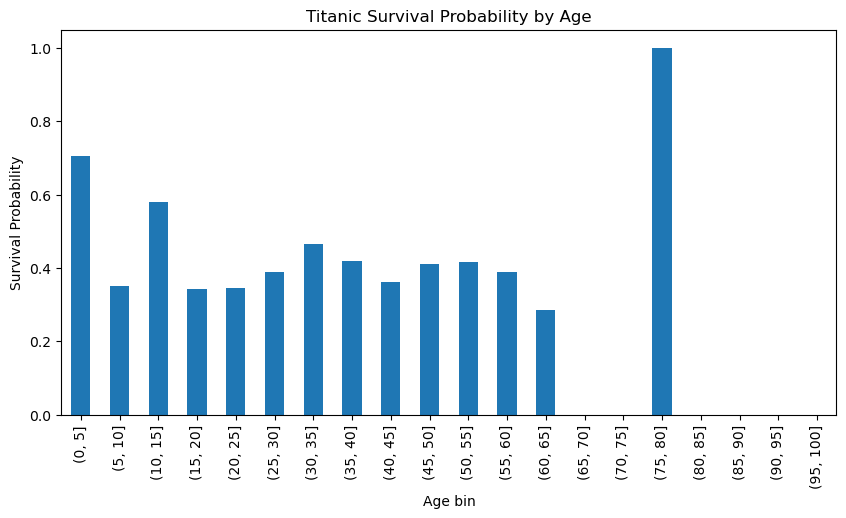

In [51]:
# Create age bins
bins = np.arange(0, 101, 5)  # 0-80 in 5-year bins
age_bin = pd.cut(train_raw["Age"], bins)

# Compute mean survival in each bin
age_survival = train_raw.groupby(age_bin)["Survived"].mean()

# Plot
age_survival.plot(kind="bar", figsize=(10, 5))
plt.ylabel("Survival Probability")
plt.xlabel("Age bin")
plt.title("Titanic Survival Probability by Age")
plt.show()

In [52]:
age_survival

Age
(0, 5]       0.704545
(5, 10]      0.350000
(10, 15]     0.578947
(15, 20]     0.343750
(20, 25]     0.344262
(25, 30]     0.388889
(30, 35]     0.465909
(35, 40]     0.417910
(40, 45]     0.361702
(45, 50]     0.410256
(50, 55]     0.416667
(55, 60]     0.388889
(60, 65]     0.285714
(65, 70]     0.000000
(70, 75]     0.000000
(75, 80]     1.000000
(80, 85]          NaN
(85, 90]          NaN
(90, 95]          NaN
(95, 100]         NaN
Name: Survived, dtype: float64

## Missing values
We analyze the missing values in the training data.

In [53]:
train_raw.notna().all() # the following code indicates that only Age, Cabin, and Embarked have missing values

PassengerId     True
Survived        True
Pclass          True
Name            True
Sex             True
Age            False
SibSp           True
Parch           True
Ticket          True
Fare            True
Cabin          False
Embarked       False
dtype: bool

In [54]:
print(f"Number of passengers without known age: {len(train_raw.loc[train_raw["Age"].isna()])} of {len(train_raw)}")
train_raw.loc[train_raw["Age"].isna()]

Number of passengers without known age: 177 of 891


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


The following code deals with the columns with NaNs

We now specify how we deal with missing values:
- We drop the cabin number, temporarily. This column isn't clean, some passengers have multiple.
- We impute the Age with the average age. We add a binary column, AgeKnown, if the age is exactly known.
- We create a new category for Embarked, M = missing

In [55]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

numeric_features = ["Fare", "SibSp", "Parch", "Fare"]
categorical_features = ["Sex", "Embarked", "AgeKnown"]
polynomial_features = ["Age"]

train_raw["AgeKnown"] = ((train_raw["Age"] % 1.0) == 0.0)|(train_raw["Age"] < 1.0)
test_raw["AgeKnown"] = ((test_raw["Age"] % 1.0) == 0.0)|(test_raw["Age"] < 1.0)


numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="M")),
    ("encoder", OneHotEncoder(drop="first"))
])

polynomial_transformer = Pipeline(steps=[
    ("numeric", numeric_transformer),
    ("expansion", PolynomialFeatures(degree=2, include_bias=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("poly", polynomial_transformer, polynomial_features)
    ]
)


## Derived features
In this section, we add certain derived features

## Logistic Regression Model

In this section, we pass our transformed data through a logistic regression model to predict whether someone survived

In [56]:
from sklearn.linear_model import LogisticRegression

clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])

X_train = train_raw.drop(columns=["PassengerId", "Survived", "Name", "Ticket", "Cabin"])
y_train = train_raw["Survived"]
X_test = test_raw.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"])

In [57]:
clf.fit(X_train, y_train)

logreg = clf.named_steps["model"]
feature_names = clf.named_steps["preprocessor"].get_feature_names_out()

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": logreg.coef_[0]
})
print(coef_df)



               feature  coefficient
0            num__Fare     0.351625
1           num__SibSp    -0.471426
2           num__Parch    -0.235973
3            num__Fare     0.351625
4        cat__Sex_male    -2.583540
5      cat__Embarked_M     0.071816
6      cat__Embarked_Q    -0.326113
7      cat__Embarked_S    -0.519624
8   cat__AgeKnown_True     0.446953
9            poly__Age    -0.342359
10         poly__Age^2     0.151420


In [61]:
y_pred = pd.Series(clf.predict(X_test))
pred_df = pd.DataFrame({"PassengerId": test_raw["PassengerId"], "Survived": y_pred})

In [62]:
pred_df.to_csv("submission.csv", index=False)
pred_df

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


## Submit Model

In [ ]:
# Uncomment code to submit model to kaggle

#!kaggle competitions submit -c titanic -f submission.csv -m "Message"

100%|██████████████████████████████████████| 2.77k/2.77k [00:00<00:00, 7.28kB/s]
Successfully submitted to Titanic - Machine Learning from Disaster